In [1]:
import pandas as pd
import numpy as np
import glob
import os
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

In [2]:
##### load Odin extractions #####

combined_ie = pd.read_csv("combined_data_ie_label.csv")
ie_extraction = combined_ie[['message_id', 'ie_extraction']]

# keep nan values for ie_extraction to have the original sequence of utterances
# annotations may have CLC labels on utt that does not have ie extraction
ie_extraction.set_index("message_id", inplace=True)

In [3]:
len(ie_extraction)

6727

In [4]:
##### load annotation #####

def readFile(dir):
    dataAll_df = pd.read_csv(dir,index_col=None, header=0).\
        fillna("NA")\
        [["message_id", "Label", "Score", "Category", "Note"]]
    # exclude pre-game and post-game lines
    # exclude no annnotation lines
    data = dataAll_df[dataAll_df["Note"] == "NA"]\
                [dataAll_df["Label"] != "NA"]\
                [["message_id", "Label", "Score", "Category"]]
    return data

In [5]:
dir_csv = glob.glob(os.path.join("CLC_annotation_MultiCat", 
                                "*.csv"))
dir_csv.sort()

dfs = (readFile(dir) for dir in dir_csv)
ann_df = pd.concat(dfs, ignore_index=True)
ann_df.set_index("message_id", inplace=True)

<ipython-input-4-35261fd994a2>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = dataAll_df[dataAll_df["Note"] == "NA"]\


In [6]:
# match the message_id in ie_extraction with ann_df 
# to include only the annotated utterances

# select items in message_id which index appears in ann_df
ie_extraction = ie_extraction[ie_extraction.index.isin(ann_df.index)]
ie_extraction = ie_extraction[~ie_extraction.index.duplicated(keep='first')]
ann_df = ann_df[ann_df.index.isin(ie_extraction.index)]

In [7]:
len(ie_extraction) == len(ann_df)

True

In [8]:
ie_extraction.reset_index(inplace=True)
ann_df.reset_index(inplace=True)
##### map ie extractions to annotation df #####
ie_dict = dict(zip(ie_extraction.message_id, ie_extraction.ie_extraction))
ann_df["ie_extraction"] = ie_extraction["message_id"].map(ie_dict)
ann_df

,message_id,Label,Score,Category,ie_extraction
0,ce97fd05-3d0d-4e6c-b9fd-4c8ecf6d6fc6,5a,NA,assert,"Agreement, Damage, Damage, KnowledgeSharing"
1,f9ba47ea-6aef-450f-9d56-8486c2d38b11,5b.6a,2.0,follow-up-question.info-request,YesNoQuestion
2,2eb63755-e786-4fda-ad8e-e9e4328f34c5,6a+,NA,info-request,Damage
3,a467ecae-10f8-4ebb-896e-e42612fa7e79,7a,NA,assert,"Agreement, Agreement, MakeCommitment, MakeComm..."
4,64d85e13-01b4-4b8d-902a-65955c2e0ea3,6b,3.0,info-provide,"KnowledgeSharing, Meeting"
...,...,...,...,...,...
4011,9fda7355-30c7-4363-9666-4f0347070a60,66c.67a,NA,acknowledge.assert,"KnowledgeSharing, TimeUnit"
4012,0f240579-dcb2-49aa-8758-138e8a8a392d,67b.68a,3.0,info-provide.assert,NaN
4013,8521d8bc-fc19-4ff3-bc77-0e1133f993fe,68a+,NA,assert,Instruction
4014,37dfcb89-3e16-41a3-ac94-b90e870b21fd,68a++,NA,assert,KnowledgeSharing


In [57]:
# check manually if all trials has ie labels attached on them
# yes.
ann_df.to_csv("ann_extend_ie.csv", index=False)

In [10]:
###### Find Call-out label set #####

# filtering the rows where Label contains 'a'
callout_df = ann_df[ann_df['Label'].str.contains('a')]

# filtering the callout_df where Category is 'assert'
callout_assert = callout_df[callout_df['Category'].str.contains('assert')]
# filtering the callout_df where Category is 'commit'
callout_commit = callout_df[callout_df['Category'].str.contains('commit')]
# filtering the callout_df where Category is 'action-directive'
callout_action = callout_df[callout_df['Category'].str.contains('action-directive')]
# filtering the callout_df where Category is 'info-request'
callout_info = callout_df[callout_df['Category'].str.contains('info-request')]

In [11]:
###### Find Check-back label set #####

# filtering the rows where Label contains 'b'
checkback_df = ann_df[ann_df['Label'].str.contains('b')]

# filtering the checkback_df where Category is 'acknowledge'
checkback_acknowledge = checkback_df[checkback_df['Category'].str.contains('acknowledge')]
# filtering the checkback_df where Category is 'accept'
checkback_accept = checkback_df[checkback_df['Category'].str.contains('accept')]
# filtering the checkback_df where Category is 'follow-up-question'
checkback_question = checkback_df[checkback_df['Category'].str.contains('follow-up-question')]
# filtering the checkback_df where Category is 'info-request'
checkback_info = checkback_df[checkback_df['Category'].str.contains('info-provide')]

In [12]:
###### Find Closing-of-the-loop label set #####

# filtering the rows where Label contains 'c'
closing_df = ann_df[ann_df['Label'].str.contains('c')]

# filtering the checkback_df where Category is 'acknowledge'
closing_acknowledge = closing_df[closing_df['Category'].str.contains('acknowledge')]
# filtering the checkback_df where Category is 'accept'
closing_accept = closing_df[closing_df['Category'].str.contains('accept')]
# filtering the checkback_df where Category is 'info-request'
closing_info = closing_df[closing_df['Category'].str.contains('info-provide')]

In [13]:
##### get label frequency for each phase and category #####

def find_label_freq(label_cat_df):
    '''takes in df of each label/label_category, e.g.callout_df/callout_assert
    and returns a list of the freq for each Odin label for that clc lable/label_category.
    e.g. [(647, 'Agreement'), (197, 'KnowledgeSharing')]'''
    label_cat_list = label_cat_df['ie_extraction'].dropna().to_list()
    label_cat_freq = {}
    for labels in label_cat_list:
        labels = labels.split(', ')
        for label in labels:
            if label not in label_cat_freq:
                label_cat_freq[label] = 1
            else:
                label_cat_freq[label] += 1
    label_cat_freq_list = sorted([(value, key) for (key, value) in label_cat_freq.items()],
                           reverse=True)
    return label_cat_freq_list

In [14]:
def all_part_bool(df_all, part_id_list):
    '''for each id in df_all, if the id in part, give a 1, else 0
    This function is used to prepare the tokenized golden and detection for acc'''
    res = []
    for id in df_all["message_id"]:
        if id in part_id_list:
            res.append(1)
        else:
            res.append(0)
    return res

def find_labelset_scores(labelset, label_cat_df):
    '''takes in a label set that selected from the Odin label freq list, and the 
    label/label category df. 
    Golden ann is a list of bool values for the all utts on whether an utt is marked with a certain label/label_cat.
    Detected is a list of bool values for all utts on whether an utt contains the Odin label that in the selected Odin label list for that clc label/label_cat.
    Returns acc, precision, recall, and f1 scores for that clc label cat'''
    ann = all_part_bool(ann_df, label_cat_df["message_id"].to_list())
    utt_label_dict = dict(zip(ann_df.message_id, ann_df.ie_extraction))
    detected_id = []
    for id, labels in utt_label_dict.items():
        found = False
        if labels == labels: ## filter out nan
            labels = labels.split(', ')
            for label in labels:
                if label in labelset:
                    found = True
        if found:
            detected_id.append(id)
    detected = all_part_bool(ann_df, detected_id)
    acc, precision, recall, f1 = round(accuracy_score(ann, detected), 3),\
                        round(precision_score(ann, detected, zero_division=1), 3),\
                        round(recall_score(ann, detected, zero_division=1), 3),\
                        round(f1_score(ann, detected, zero_division=1), 3)
    return acc, precision, recall, f1

    

In [15]:
def print_labelset_scores(labelset, label_cat_df):
    acc, precision, recall, f1 = find_labelset_scores(labelset, label_cat_df)
    print("acc: ", acc)
    print("precision: ", precision)
    print("recall: ", recall)
    print("f1: ", f1)

In [16]:
def plot_scores(labelset, label_cat_df):
    '''Taking n of labels as the x_values, 
    the acc, precision, recall and f1 scores as y_values,
    and line plot them'''
    x_values = range(len(labelset))
    y_acc, y_precision, y_recall, y_f1 = [], [], [], []
    for i in x_values:
        acc, precision, recall, f1 = find_labelset_scores(labelset[:i], label_cat_df)
        y_acc.append(acc)
        y_precision.append(precision)
        y_recall.append(recall)
        y_f1.append(f1)
    scores_df = pd.DataFrame({'x_values':x_values,
                              'accuracy':y_acc,
                              'precision':y_precision,
                              'recall':y_recall,
                              'f1':y_f1})
    plt.plot( 'x_values', 'accuracy', data=scores_df, marker='', color='#D95319', linewidth=2)
    plt.plot( 'x_values', 'precision', data=scores_df, marker='', color='#0072BD', linewidth=2)
    plt.plot( 'x_values', 'recall', data=scores_df, marker='', color='#7E2F8E', linewidth=2)
    plt.plot( 'x_values', 'f1', data=scores_df, marker='', color='#77AC30', linewidth=2)
    # show legend
    plt.legend()
    # show graph
    plt.show()


In [17]:
##### Call-out: assert #####
assert_labels = find_label_freq(callout_assert)
assert_labels = [i[1] for i in assert_labels]

In [18]:
##### Call-out: commit #####
commit_labels = find_label_freq(callout_commit)
commit_labels = [i[1] for i in commit_labels]

In [19]:
##### Call-out: action-directive #####
action_labels = find_label_freq(callout_action)
action_labels = [i[1] for i in action_labels]

In [20]:
##### Call-out: info-request #####
info_labels = find_label_freq(callout_info)
info_labels = [i[1] for i in info_labels]

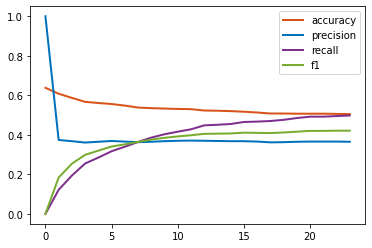

In [21]:
##### Call-out: assert accuracy #####
plot_scores(assert_labels[1:25], callout_assert)

In [70]:
print_labelset_scores(assert_labels[1:12], callout_assert)

acc:  0.53
precision:  0.371
recall:  0.428
f1:  0.398


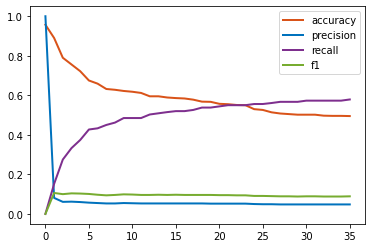

In [71]:
##### Call-out: commit accuracy #####
plot_scores(commit_labels[1:], callout_commit)

In [72]:
print_labelset_scores(commit_labels[1:10], callout_commit)

acc:  0.622
precision:  0.055
recall:  0.485
f1:  0.099


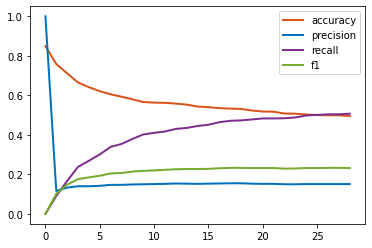

In [73]:
##### Call-out: action-directive accuracy #####
plot_scores(action_labels[1:30], callout_action)

In [75]:
print_labelset_scores(action_labels[1:15], callout_action)

acc:  0.543
precision:  0.152
recall:  0.445
f1:  0.227


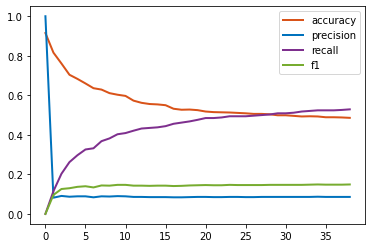

In [76]:
##### Call-out: info-request accuracy #####
plot_scores(info_labels[1:], callout_info)

In [77]:
print_labelset_scores(info_labels[1:10], callout_info)

acc:  0.603
precision:  0.09
recall:  0.403
f1:  0.147


In [22]:
##### Call-out: whole labelset accuracy #####
callout_labels = find_label_freq(callout_df)
callout_labels = [i[1] for i in callout_labels]

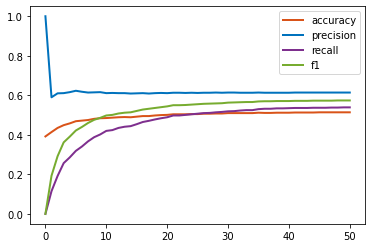

In [23]:
plot_scores(callout_labels[1:], callout_df)

In [27]:
print_labelset_scores(callout_labels[1:25], callout_df)

acc:  0.505
precision:  0.613
recall:  0.504
f1:  0.553


In [81]:
##### Check-back: acknowledge #####
cb_acknowledge = find_label_freq(checkback_acknowledge)
cb_acknowledge = [i[1] for i in cb_acknowledge]

In [82]:
##### Check-back: accept #####
cb_accept = find_label_freq(checkback_accept)
cb_accept = [i[1] for i in cb_accept]

In [83]:
##### Check-back: follow-up-question #####
cb_question = find_label_freq(checkback_question)
cb_question = [i[1] for i in cb_question]

In [84]:
##### Check-back: info-provide #####
cb_info = find_label_freq(checkback_info)
cb_info = [i[1] for i in cb_info]

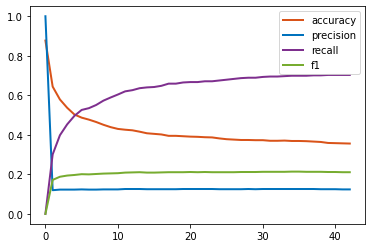

In [85]:
##### Check-back: acknowledge accuracy #####
plot_scores(cb_acknowledge, checkback_acknowledge)

In [86]:
print_labelset_scores(cb_acknowledge[:7], checkback_acknowledge)

acc:  0.465
precision:  0.123
recall:  0.551
f1:  0.202


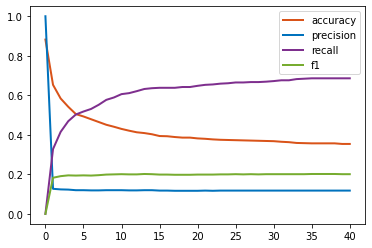

In [87]:
##### Check-back: accept accuracy #####
plot_scores(cb_accept, checkback_accept)

In [91]:
print_labelset_scores(cb_accept[:5], checkback_accept)

acc:  0.493
precision:  0.12
recall:  0.518
f1:  0.195


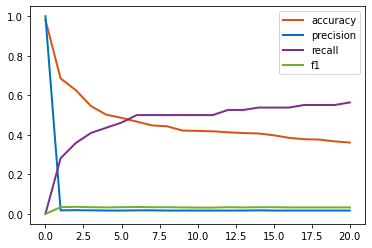

In [89]:
##### Check-back: follow-up-question accuracy #####
plot_scores(cb_question, checkback_question)

In [92]:
print_labelset_scores(cb_question[:5], checkback_question)

acc:  0.486
precision:  0.017
recall:  0.462
f1:  0.034


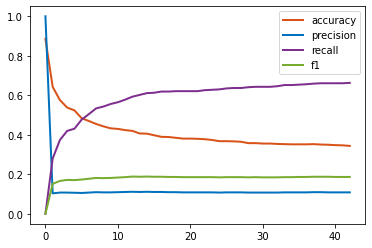

In [93]:
##### Check-back: info-provide accuracy #####
plot_scores(cb_info, checkback_info)

In [94]:
print_labelset_scores(cb_info[:5], checkback_info)

acc:  0.484
precision:  0.106
recall:  0.477
f1:  0.174


In [28]:
##### Check-back: whole labelset accuracy #####
checkback_labels = find_label_freq(checkback_df)
checkback_labels = [i[1] for i in checkback_labels]

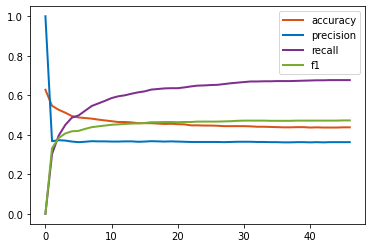

In [29]:
plot_scores(checkback_labels, checkback_df)

In [32]:
print_labelset_scores(checkback_labels[:4], checkback_df)

acc:  0.495
precision:  0.366
recall:  0.487
f1:  0.418


In [46]:
for i in checkback_labels[:4]:
    print(i)
    print()

Agreement

KnowledgeSharing

YesNoQuestion

DeliberatePlan



In [99]:
##### Closing-of-the-loop: acknowledge #####
cl_acknowledge = find_label_freq(closing_acknowledge)
cl_acknowledge = [i[1] for i in cl_acknowledge]

In [100]:
##### Closing-of-the-loop: accept #####
cl_accept = find_label_freq(closing_accept)
cl_accept = [i[1] for i in cl_accept]

In [101]:
##### Closing-of-the-loop: info-provide #####
cl_info = find_label_freq(closing_info)
cl_info = [i[1] for i in cl_info]

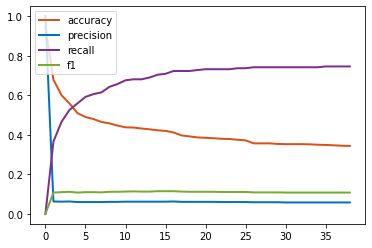

In [102]:
##### Closing-of-the-loop: acknowledge accuracy #####
plot_scores(cl_acknowledge, closing_acknowledge)

In [103]:
print_labelset_scores(cl_acknowledge[:3], closing_acknowledge)

acc:  0.559
precision:  0.063
recall:  0.526
f1:  0.112


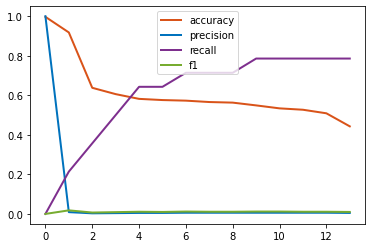

In [104]:
##### Closing-of-the-loop: accept accuracy #####
plot_scores(cl_accept, closing_accept)

In [105]:
print_labelset_scores(cl_accept[:4], closing_accept)

acc:  0.582
precision:  0.005
recall:  0.643
f1:  0.011


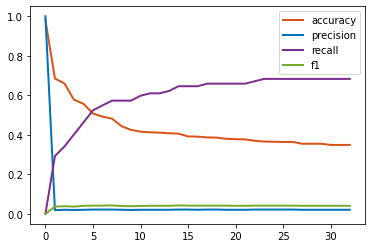

In [106]:
##### Closing-of-the-loop: info-provide accuracy #####
plot_scores(cl_info, closing_info)

In [107]:
print_labelset_scores(cl_info[:5], closing_info)

acc:  0.508
precision:  0.022
recall:  0.524
f1:  0.042


In [33]:
##### Closing-of-the-loop: whole labelset accuracy #####
closing_labels = find_label_freq(closing_df)
closing_labels = [i[1] for i in closing_labels]

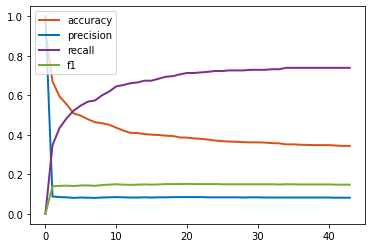

In [34]:
plot_scores(closing_labels, closing_df)

In [40]:
print_labelset_scores(closing_labels[:2], closing_df)

acc:  0.594
precision:  0.085
recall:  0.435
f1:  0.142


In [39]:
for i in closing_labels[:3]

['Agreement', 'KnowledgeSharing', 'DeliberatePlan']

In [47]:
import json

callout_selection = callout_labels[1:25]
checkback_selection = checkback_labels[:4]
closing_selection = closing_labels[:2]

label_selection = {"callout_selection": callout_selection,
                   "checkback_selection": checkback_selection,
                   "closing_selection": closing_selection}
with open('label_selection.json', 'w') as file:
    json.dump(label_selection, file)